In [1]:
import numpy as np 
import h5py
import matplotlib.pyplot as plt

In [2]:
G3Xd = h5py.File('./data/G3X-profiles-progenitors_steMetal.hdf5','r')
GIZd = h5py.File('./data/GIZ-profiles-progenitors_steMetal.hdf5','r')

In [3]:
'''
calculate median profiles and percentile error [16,84] statistically

mod: simulation name [GIZMO or GadgetX]
d: simulation data
snap: which snapshot (equally redshift)
region: which property
ntclu: total cluster number (few clusters may not form at high redshift)
part: which particle part (default 0, this is not meaning DM particles)
'''
def cal_median(rbin, value, nbin):
    xmed = np.zeros(nbin)
    ymed = np.zeros(nbin)
    yerr = np.zeros(shape = (2,nbin))
    
    #calculate the median profile
    for j in range(nbin):
#         nonan = np.where((value[:,j]!= 0) & (np.isnan(value[:,j]) == False))[0]
        nonan = np.where((np.isnan(value[:,j]) == False))[0]
        if len(nonan) > 1:
            ymed[j] = np.median(value[nonan,j])
            xmed[j] = np.median(rbin[nonan,j])
            yerrtot = np.percentile(value[nonan,j],[16,84])
            yerr[0,j] = yerrtot[0]
            yerr[1,j] = yerrtot[1]
    return xmed,ymed,yerr


def cal_sta_profiles(mod,d,snap,region,bin25,ntclu,part = 0):
    nbin = 50
    allvalue=np.zeros(shape = (ntclu,nbin))
    rbinvalue=np.zeros(shape = (ntclu,nbin))
    npvalue=np.zeros(shape = (ntclu,nbin))
    redshift = d['NewMDCLUSTER_0001/snap_%03d'%(snap)].attrs['redshift']
    i = 0
    #read raw data
    for nclu in range(324):
        if 'Rbin' not in d['NewMDCLUSTER_0%03d/snap_%03d'%(nclu+1, snap)]:          
            continue
        r500 = d['NewMDCLUSTER_%04d/snap_%03d'%(nclu+1,snap)].attrs['r500']
        r200 = d['NewMDCLUSTER_%04d/snap_%03d'%(nclu+1,snap)].attrs['r200']
        allvalue[i] = d['NewMDCLUSTER_%04d/snap_%03d/%s'%(nclu+1,snap,region)][:]
        rbinvalue[i] = d['NewMDCLUSTER_%04d/snap_%03d/Rbin'%(nclu+1,snap)][:] / r200 #unit: r/r200
        npvalue[i] = d['NewMDCLUSTER_%04d/snap_%03d/NuminBin'%(nclu+1,snap)][1]
        i+=1
    print(i)
                
    if bin25 == True:
        # combine nearby bins with near 2
        rbin25 = np.zeros(shape = (ntclu, 25))
        value25 = np.zeros(shape = (ntclu, 25))
        np25 = np.zeros(shape = (ntclu, 25))
        for i in range(ntclu):
            for j in range(25):
                bin0 = j*2
                bin1 = j*2+1
                value25[i,j] = (allvalue[i,bin0] + allvalue[i,bin1]) / 2
                rbin25[i,j] = (rbinvalue[i,bin0] + rbinvalue[i,bin1]) / 2
                np25[i,j] = npvalue[i,bin0] + npvalue[i,bin1]
        
        np25 = np.sum(np25, axis = 1)
        idnp = np.where(np25 >= 50)[0]
        print('input sample is', idnp.shape[0])
        return cal_median(rbin25[idnp], value25[idnp], 25)
    else:
        npvalue = np.sum(npvalue, axis = 1)
        idnp = np.where(npvalue >= 50)[0]
        print('input sample is', idnp.shape[0])
        return cal_median(rbinvalue[idnp], allvalue[idnp], 50)

324
input sample is 312
324
input sample is 312
324
input sample is 324
324
input sample is 324
GIZ radius [0.00347613 0.00402363 0.00465736 0.0053909  0.00623998 0.00722279
 0.0083604  0.00967718 0.01120135 0.01296559 0.0150077  0.01737144
 0.02010749 0.02327446 0.02694024 0.03118338 0.03609483 0.04177985
 0.04836027 0.05597712 0.06479364 0.07499878 0.08681125 0.10048421
 0.1163107  0.13462989 0.15583439 0.18037865 0.20878868 0.24167336
 0.27973745 0.32379671 0.37479541 0.43382651 0.50215514 0.58124568
 0.67279315 0.77875955 0.90141589 1.04339088 1.20772724 1.39794693]
G3X radius [0.00465736 0.0053909  0.00623998 0.00722279 0.0083604  0.00967718
 0.01120135 0.01296559 0.0150077  0.01737144 0.02010749 0.02327446
 0.02694024 0.03118338 0.03609483 0.04177985 0.04836027 0.05597712
 0.06479364 0.07499878 0.08681125 0.10048421 0.1163107  0.13462989
 0.15583439 0.18037865 0.20878868 0.24167336 0.27973745 0.32379671
 0.37479541 0.43382651 0.50215514 0.58124568 0.67279315 0.77875955
 0.9014158

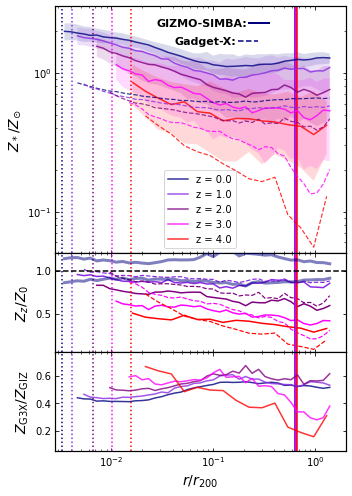

In [12]:
#Combined results
from astropy.cosmology import FlatLambdaCDM
plt.figure(figsize = (5,7))
import matplotlib as mpl
mpl.rcParams['axes.linewidth'] = 1.2 #set the value globally
cosmo = FlatLambdaCDM(H0=67.77, Om0=0.307115)

#divide grids for figure
ax1 = plt.subplot2grid((9,4),(0,0),colspan = 4,rowspan = 5)
ax10 = plt.subplot2grid((9,4),(5,0),colspan = 4,rowspan = 2)
ax20 = plt.subplot2grid((9,4),(7,0),colspan = 4,rowspan = 2)

snapb = [128,96,78,65,55,47,40]
redb = ['z = 0.0','z = 1.0','z = 2.0','z = 3.0','z = 4.0','z = 5.0','z = 6.0']
# colall = ['b','r','k','orange','cyan','magenta','green']
colall = ['navy','blueviolet','purple','magenta','r','tomato','orange']
nGIZ = [324,324,323,323,323,318,306]
nG3X = [324,324,324,323,323,320,305]
# idtGIZ = [37,31,26,21,9,7,7]
# idtG3X = [37,33,27,21,8,8,9]
idtGIZ = [0,0,0,0,0,0,0]
idtG3X = [0,0,0,0,0,0,0]

softl_GIZ = [0.0033, 0.0041, 0.0067, 0.0102, 0.0155]
softl_G3X = [0.0043, 0.0053, 0.0086, 0.0133, 0.0198]
#==========================================================

# GIZMO
#Gadget-X      
for i in [0,1,2,3,4]:
    if i == 0:
        xmed0,ymed0,yerr0 = cal_sta_profiles('GIZ',GIZd,snapb[i],'MWMetal',False,nGIZ[i])
        xmed25,ymed25,yerr25 = cal_sta_profiles('GIZ',GIZd,snapb[i],'MWMetal',True,nGIZ[i])
        # idt = (yerr0[0] > 0)
        idt = np.where((yerr0[0] > 0) & (xmed0 > softl_GIZ[i]))[0]

        ax1.plot(xmed0[idt],ymed0[idt],lw = 1.5, label = redb[i],c=colall[i],zorder = 20, alpha=0.8)
        ax1.fill_between(xmed0[idt],yerr0[0,idt],yerr0[1,idt],color = colall[i],alpha = 0.15, edgecolor = 'none')
        ax10.plot(xmed0[idt],yerr0[0,idt]/ymed0[idt],lw = 3, c='navy', ls = '-', alpha = 0.5, zorder = 500)
        ax10.plot(xmed0[idt],yerr0[1,idt]/ymed0[idt],lw = 3, c='navy', ls = '-', alpha = 0.5, zorder = 500)
        
        xmed0_x,ymed0_x,yerr0_x = cal_sta_profiles('G3X',G3Xd,snapb[i],'MWMetal',False,nG3X[i])
        xmed25_x,ymed25_x,yerr25_x = cal_sta_profiles('G3X',G3Xd,snapb[i],'MWMetal',True,nG3X[i])
        # idt_x = (yerr0_x[0] != 0)
        idt_x = np.where((yerr0_x[0] != 0) & (xmed0_x > softl_G3X[i]))[0]
        ax1.plot(xmed0_x[idt_x],ymed0_x[idt_x],lw = 1.2, ls = '--',  c=colall[i], zorder = 30,alpha = 0.8)
        
        ax20.plot(xmed0_x[idt_x],ymed0_x[idt_x]/ymed0[idt_x], c=colall[i], zorder = 30,alpha = 0.8)
        
        print('GIZ radius',xmed0[idt])
        print('G3X radius',xmed0_x[idt_x])
        
    elif i <= 3:
        xmed,ymed,yerr = cal_sta_profiles('GIZ',GIZd,snapb[i],'MWMetal',False,nGIZ[i])
        # idt = (yerr[0] > 0)
        idt = np.where((yerr[0] > 0) & (xmed > softl_GIZ[i]))[0]
        ax1.plot(xmed[idt],ymed[idt],lw = 1.5, label = redb[i],c=colall[i],zorder = 20, alpha = 0.8)
        ax1.fill_between(xmed[idt],yerr[0,idt],yerr[1,idt],color = colall[i],alpha = 0.15, edgecolor = 'none')
        ax10.plot(xmed[idt],ymed[idt]/ymed0[idt],lw = 1.5, c=colall[i])
        
        xmed_x,ymed_x,yerr_x = cal_sta_profiles('G3X',G3Xd,snapb[i],'MWMetal',False,nG3X[i])
        # idt_x = (yerr_x[0] != 0)
        idt_x = np.where((yerr_x[0] != 0) & (xmed_x > softl_G3X[i]))[0]
        ax1.plot(xmed_x[idt_x], ymed_x[idt_x], lw = 1.2, ls = '--', c=colall[i], zorder = 30, alpha = 0.8)
        ax10.plot(xmed_x[idt_x], ymed_x[idt_x]/ymed0_x[idt_x],c=colall[i], lw = 1.2, ls = '--')
        
        ax20.plot(xmed_x[idt_x],ymed_x[idt_x]/ymed[idt_x], c=colall[i], zorder = 30,alpha = 0.8)
        
    else:
        xmed,ymed,yerr = cal_sta_profiles('GIZ',GIZd,snapb[i],'MWMetal',True,nGIZ[i])
        # idt = (yerr[0] > 0)
        idt = np.where((yerr[0] > 0) & (xmed > softl_GIZ[i]))[0]
        ax1.plot(xmed[idt],ymed[idt],lw = 1.5, label = redb[i],c=colall[i],zorder = 20, alpha = 0.8)
        ax1.fill_between(xmed[idt],yerr[0,idt],yerr[1,idt],color =colall[i],alpha = 0.15, edgecolor = 'none')
        ax10.plot(xmed[idt],ymed[idt]/ymed25[idt],lw = 1.5, c=colall[i])
        
        xmed_x,ymed_x,yerr_x = cal_sta_profiles('G3X',G3Xd,snapb[i],'MWMetal',True,nG3X[i])
        # idt_x = (yerr_x[0] != 0)
        idt_x = np.where((yerr_x[0] != 0) & (xmed_x > softl_G3X[i]))[0]
        ax1.plot(xmed_x[idt_x], ymed_x[idt_x], lw = 1.2, ls = '--', c=colall[i], zorder = 30, alpha = 0.8)
        ax10.plot(xmed_x[idt_x],ymed_x[idt_x]/ymed25_x[idt_x],c=colall[i], lw = 1.2, ls = '--')
        
        ax20.plot(xmed_x[idt_x],ymed_x[idt_x]/ymed[idt_x], c=colall[i], zorder = 30,alpha = 0.8)
    print(idt[idt == True].shape)
    
    
GIZ_500 = [0.6401, 0.6406, 0.6450, 0.6543, 0.6633, 0.6703, 0.6723]
G3X_500 = [0.6449, 0.6483, 0.6464, 0.6505, 0.6621, 0.6665, 0.6708]

for i in range(5):
    ax1.axvline(GIZ_500[i], color = colall[i], ls = '-')
    ax10.axvline(GIZ_500[i], color = colall[i], ls = '-')
    ax20.axvline(GIZ_500[i], color = colall[i], ls = '-')
    
    ax1.axvline(softl_GIZ[i], color = colall[i], ls = ':')
    ax10.axvline(softl_GIZ[i], color = colall[i], ls = ':')
    ax20.axvline(softl_GIZ[i], color = colall[i], ls = ':')
    
ax1.text(0.0278,2.16,'GIZMO-SIMBA:',weight = 'bold',size = 11) 
ax1.text(0.042,1.6,'Gadget-X:',weight = 'bold',size = 11) 

from matplotlib.lines import Line2D
lin1 = Line2D([],[],c = 'navy',lw = 2)
legend2 = ax1.legend(handles=[lin1],frameon = False, loc = (0.655,0.895))
ax1.add_artist(legend2)

lin0 = Line2D([],[],c = 'navy',lw = 1.5, ls = '--')
legend0 = ax1.legend(handles=[lin0],frameon = False, loc = (0.615,0.82))
ax1.add_artist(legend0)


#==========================================================================
# ax10.grid(c = 'grey', ls = '--', alpha = 0.5)
ax10.axhline(1,c='k',ls='--')

ax1.set_ylabel(r'$Z_*/Z_{\odot}$', fontsize = 14)
ax1.loglog()
ax1.legend( ncol = 1, loc = 'best')
ax1.set_xticklabels([])
# ax1.set_xticks()
ax1.set_ylim(5e-2,3)
ax1.set_xlim(2.8e-3,2)
# ax1.grid(c = 'grey', ls = '--', alpha = 0.5)
ax10.set_xscale('log')
ax10.set_xlim(2.8e-3,2)
ax10.set_ylim(0.05,1.2)
# ax10.set_yscale('log')
ax10.set_xticklabels([])
# ax10.set_yticks([0.1,20])
# ax10.set_yticklabels([0.5,1,1.5,2])
# ax10.set_xlabel(r'$r/r_{200}$', fontsize = 14)
ax10.set_ylabel(r'$Z_{z}/Z_{0}$', fontsize = 14)

ax20.axhline(1,c='k',ls='--')
ax20.set_xscale('log')
# ax20.set_yscale('log')
ax20.set_xlim(2.8e-3,2)
ax20.set_ylim(0.05,0.77)

ax20.set_xlabel(r'$r/r_{200}$', fontsize = 14)
ax20.set_ylabel(r'$Z_{\rm G3X}/Z_{\rm GIZ}$', fontsize = 14)
ax20.tick_params(top = 'on', right = 'on', which='both',direction = 'in',labelsize = 10)

ax1.tick_params(top = 'on', right = 'on', which='both',direction = 'in', labelsize = 10)
ax10.tick_params(top = 'on', right = 'on', which='both',direction = 'in', labelsize = 10)
plt.tight_layout()
plt.subplots_adjust(wspace = 0 , hspace = 0)

plt.savefig('./figs/SteMWmetal.pdf')

In [ ]:
#study evolution of gas density
from astropy.cosmology import FlatLambdaCDM
plt.figure(figsize = (9.5,5))
cosmo = FlatLambdaCDM(H0=67.77, Om0=0.307115)

#divide grids for figure
ax1 = plt.subplot2grid((7,8),(0,0),colspan = 4,rowspan = 5)
ax2 = plt.subplot2grid((7,8),(0,4),colspan = 4,rowspan = 5)
ax10 = plt.subplot2grid((7,8),(5,0),colspan = 4,rowspan = 2)
ax20 = plt.subplot2grid((7,8),(5,4),colspan = 4,rowspan = 2)

snapb = [128,95,78,65,55,47,40]
redb = ['z = 0','z = 1.076','z = 2.021','z = 3.027','z = 4.018','z = 5.0','z = 6.0']
colall = ['b','r','k','orange','cyan','magenta','green']
nGIZ = [324,324,323,323,323,318,306]
nG3X = [324,324,324,323,323,320,305]

for i in range(7):
    if i == 0:
        xmed0,ymed0,yerr = cal_sta_profiles('GIZ',GIZd,snapb[i],'Stellardens',nGIZ[i])
        ax1.plot(xmed0,ymed0,label = redb[i],c=colall[i])
    else:
        xmed,ymed,yerr = cal_sta_profiles('GIZ',GIZd,snapb[i],'Stellardens',nGIZ[i])
        ax1.plot(xmed,ymed,label = redb[i],c=colall[i])
        ax10.plot(xmed,ymed/ymed0,c=colall[i])
    # plt.fill_between(xmed,yerr[0],yerr[1],alpha = 0.25)

ax10.grid(c = 'grey', ls = '--', alpha = 0.5)
ax10.axhline(1,c='grey',ls='--')

ax1.text(0.4,1e7,'GIZMO',weight = 'bold',size = 11)
ax1.set_ylabel(r'$\rho_*/\rho_{\rm crit}$')
ax1.loglog()
ax1.legend(fontsize = 'x-small', loc = 3)
ax1.axes.xaxis.set_ticklabels([])
ax1.set_ylim(1e-2,1e8)
ax1.set_xlim(1e-3,2.5)
ax1.grid(c = 'grey', ls = '--', alpha = 0.5)
ax10.set_xscale('log')
ax10.set_xlim(1e-3,2.5)
ax10.set_ylim(0.05,3)
ax10.set_yticks([0.5,1,2])
ax10.set_yticklabels([0.5,1,2])
ax10.set_xlabel(r'$r/r_{200}$')
ax10.set_ylabel(r'$\rho_z/\rho_0$')

#Gadget-X
for i in range(7):
    if i == 0:
        xmed0,ymed0,yerr = cal_sta_profiles('G3X',G3Xd,snapb[i],'Stellardens',nG3X[i])
        ax2.plot(xmed0,ymed0,label = redb[i],c=colall[i])
    else:
        xmed,ymed,yerr = cal_sta_profiles('G3X',G3Xd,snapb[i],'Stellardens',nG3X[i])
        ax2.plot(xmed,ymed,label = redb[i],c=colall[i])
        ax20.plot(xmed0,ymed/ymed0,c=colall[i])
    # plt.fill_between(xmed,yerr[0],yerr[1],alpha = 0.25)

ax20.grid(c = 'grey', ls = '--', alpha = 0.5)
ax20.axhline(1,c='grey',ls='--')
ax2.text(0.4,1e7,'Gadget-X',weight = 'bold',size = 11)

ax2.loglog()
ax2.axes.xaxis.set_ticklabels([])
ax2.axes.yaxis.set_ticklabels([])
ax2.grid(c = 'grey', ls = '--', alpha = 0.5)
ax2.set_ylim(1e-2,1e8)
ax2.set_xlim(1e-3,2.5)

ax20.set_xscale('log')
ax20.set_xlim(1e-3,2.5)
ax20.set_ylim(0.05,3)
ax20.set_xlabel(r'$r/r_{200}$')
ax20.set_yticks([0.5,1,2])
ax20.axes.yaxis.set_ticklabels([])
# plt.savefig('./figs/Gdens.pdf')
# plt.tight_layout()

<IPython.core.display.Javascript object>


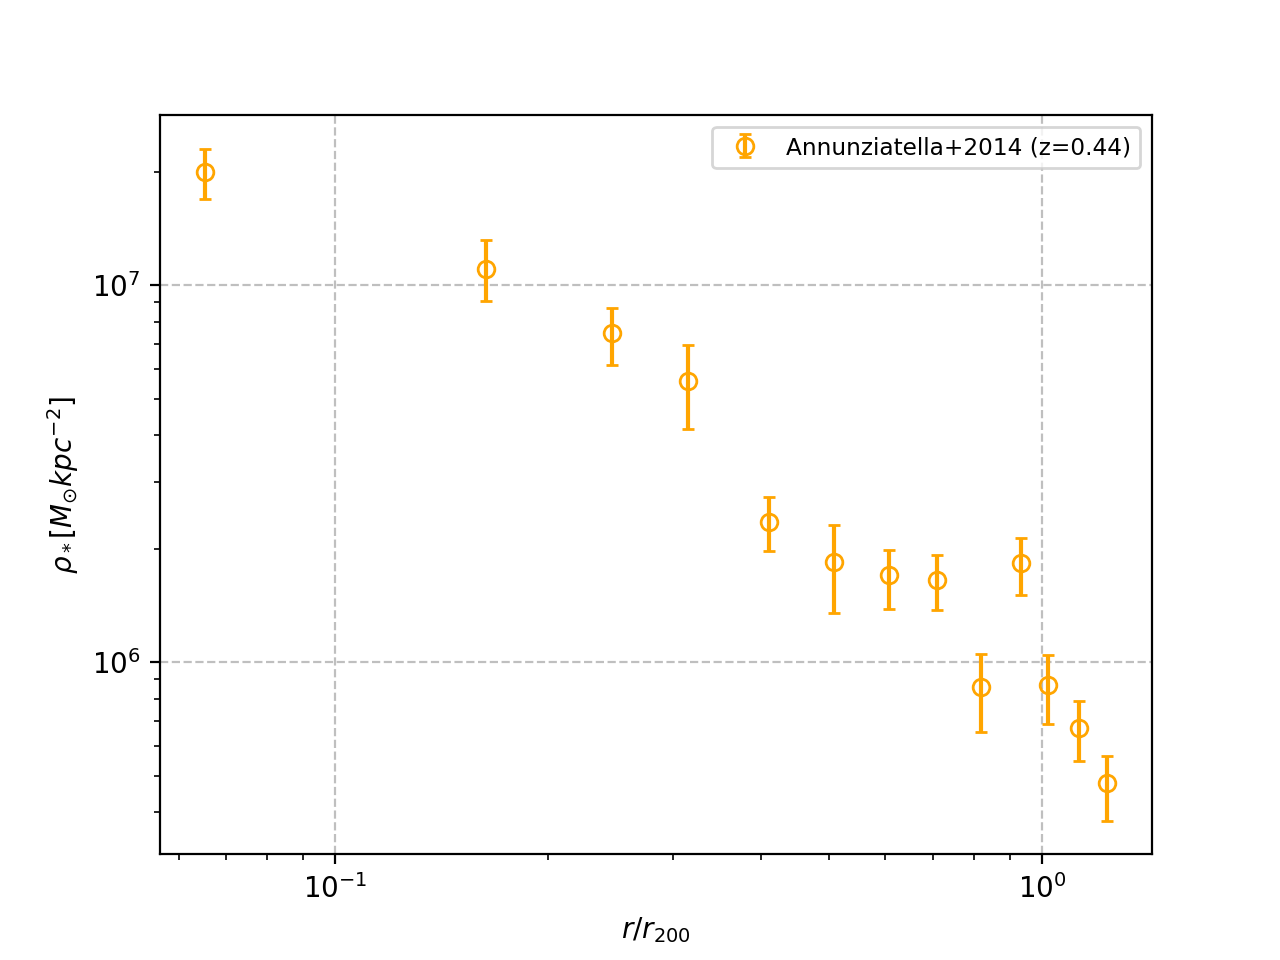

In [13]:
def ob_Stellardens():
    #---------------------------
    #Annunziatella+2014
    m0 = np.loadtxt(open('./data/ob_Stellardens/An2014_m.csv', 'r'),delimiter = ',')
    u0 = np.loadtxt(open('./data/ob_Stellardens/An2014_u.csv', 'r'),delimiter = ',')
    d0 = np.loadtxt(open('./data/ob_Stellardens/An2014_d.csv', 'r'),delimiter = ',')
    pcri = critical_density(redshift).to('kpc-3Msun').value / 0.6777**2 / (1 + 0.44)**3
    r200 = 1.96 #Mpc
    yerru = (u0[:,1] - m0[:,1])*1e10 / 1e6 / pcri
    yerrd = (m0[:,1] - d0[:,1])*1e10 / 1e6 / pcri
    plt.errorbar(m0[:,0]/r200,m0[:,1]*1e10/1e6 / pcri, yerr = [yerrd, yerru], c= 'orange', label = 'Annunziatella+2014 (z=0.44)',
                capsize = 2, zorder = 30, fmt = 'o',mfc = 'none')  
    
plt.figure()

ob_Stellardens()

plt.xlabel(r'$r/r_{200}$')
plt.ylabel(r'$\rho_*[M_{\odot}kpc^{-2}]$')
plt.loglog()
plt.legend(fontsize = 'small')
plt.grid(c = 'grey', ls = '--', alpha = 0.5)

<IPython.core.display.Javascript object>


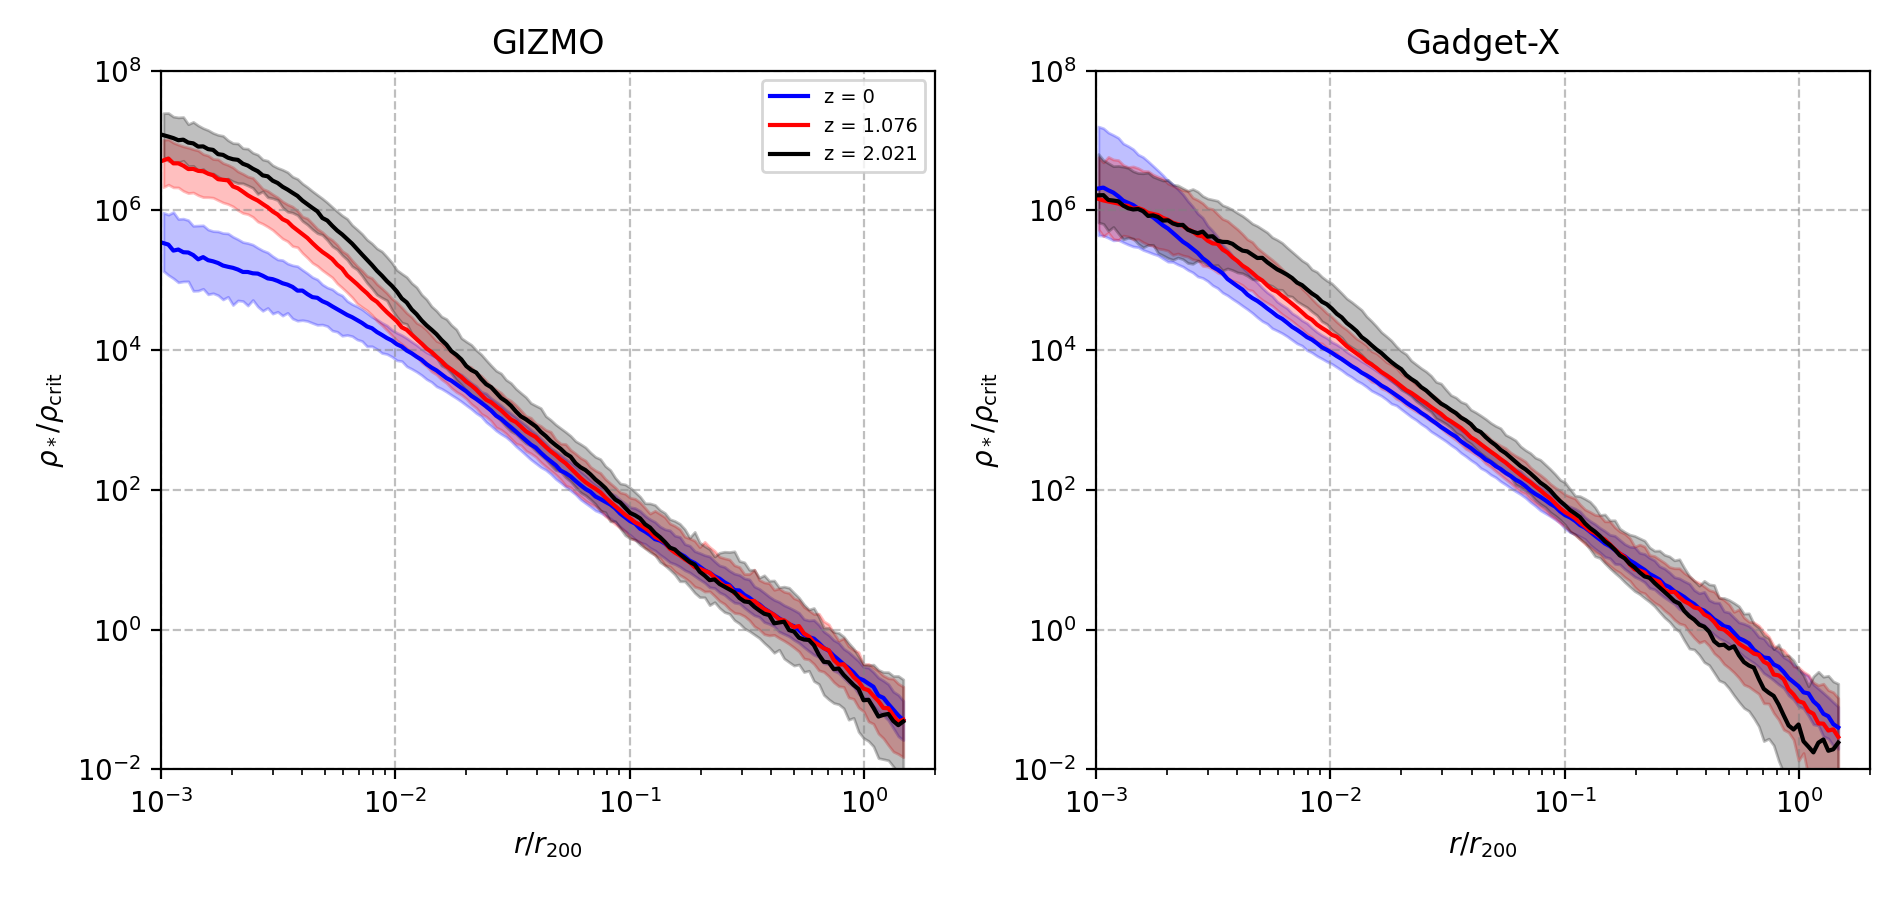

324
324
323
324
324
324


In [23]:
#stellar mass density

plt.figure(figsize = (9.5,4.5))

plt.subplot(121)
#z = 0
xmed,ymed,yerr = cal_sta_profiles('GIZ',GIZd,128,'Stellardens',324)
plt.plot(xmed,ymed,c='b',label = 'z = 0')
plt.fill_between(xmed,yerr[0],yerr[1],color = 'b',alpha = 0.25)
#z = 1.076
xmed,ymed,yerr = cal_sta_profiles('GIZ',GIZd,95,'Stellardens',324)
plt.plot(xmed,ymed,c='r',label = 'z = 1.076')
plt.fill_between(xmed,yerr[0],yerr[1],color = 'r',alpha = 0.25)
#z = 2.021
xmed,ymed,yerr = cal_sta_profiles('GIZ',GIZd,78,'Stellardens',323)
plt.plot(xmed,ymed,c='k',label = 'z = 2.021')
plt.fill_between(xmed,yerr[0],yerr[1],color = 'k',alpha = 0.25)

# ob_Stellardens()

plt.title('GIZMO')
plt.xlabel(r'$r/r_{200}$')
# plt.ylabel(r'$\rho_*[M_{\odot}kpc^{-3}]$')
plt.ylabel(r'$\rho_*/\rho_{\rm crit}$')
plt.loglog()
plt.legend(fontsize = 'x-small')
plt.ylim(1e-2,1e8)
plt.xlim(1e-3,2.)
plt.grid(c = 'grey', ls = '--', alpha = 0.5)


plt.subplot(122)
#z = 0
xmed,ymed,yerr = cal_sta_profiles('G3X',G3Xd,128,'Stellardens',324)
plt.plot(xmed,ymed,c='b',label = 'z = 0')
plt.fill_between(xmed,yerr[0],yerr[1],color = 'b',alpha = 0.25)
#z = 1.076
xmed,ymed,yerr = cal_sta_profiles('G3X',G3Xd,95,'Stellardens',324)
plt.plot(xmed,ymed,c='r',label = 'z = 1.076')
plt.fill_between(xmed,yerr[0],yerr[1],color = 'r',alpha = 0.25)
#z = 2.021
xmed,ymed,yerr = cal_sta_profiles('G3X',G3Xd,78,'Stellardens',324)
plt.plot(xmed,ymed,c='k',label = 'z = 2.021')
plt.fill_between(xmed,yerr[0],yerr[1],color = 'k',alpha = 0.25)

# ob_Stellardens()

plt.title('Gadget-X')
plt.xlabel(r'$r/r_{200}$')
# plt.ylabel(r'$\rho_*[M_{\odot}kpc^{-3}]$')
plt.ylabel(r'$\rho_*/\rho_{\rm crit}$')
plt.loglog()
plt.ylim(1e-2,1e8)
plt.xlim(1e-3,2.)
plt.grid(c = 'grey', ls = '--', alpha = 0.5)

plt.tight_layout()

<IPython.core.display.Javascript object>


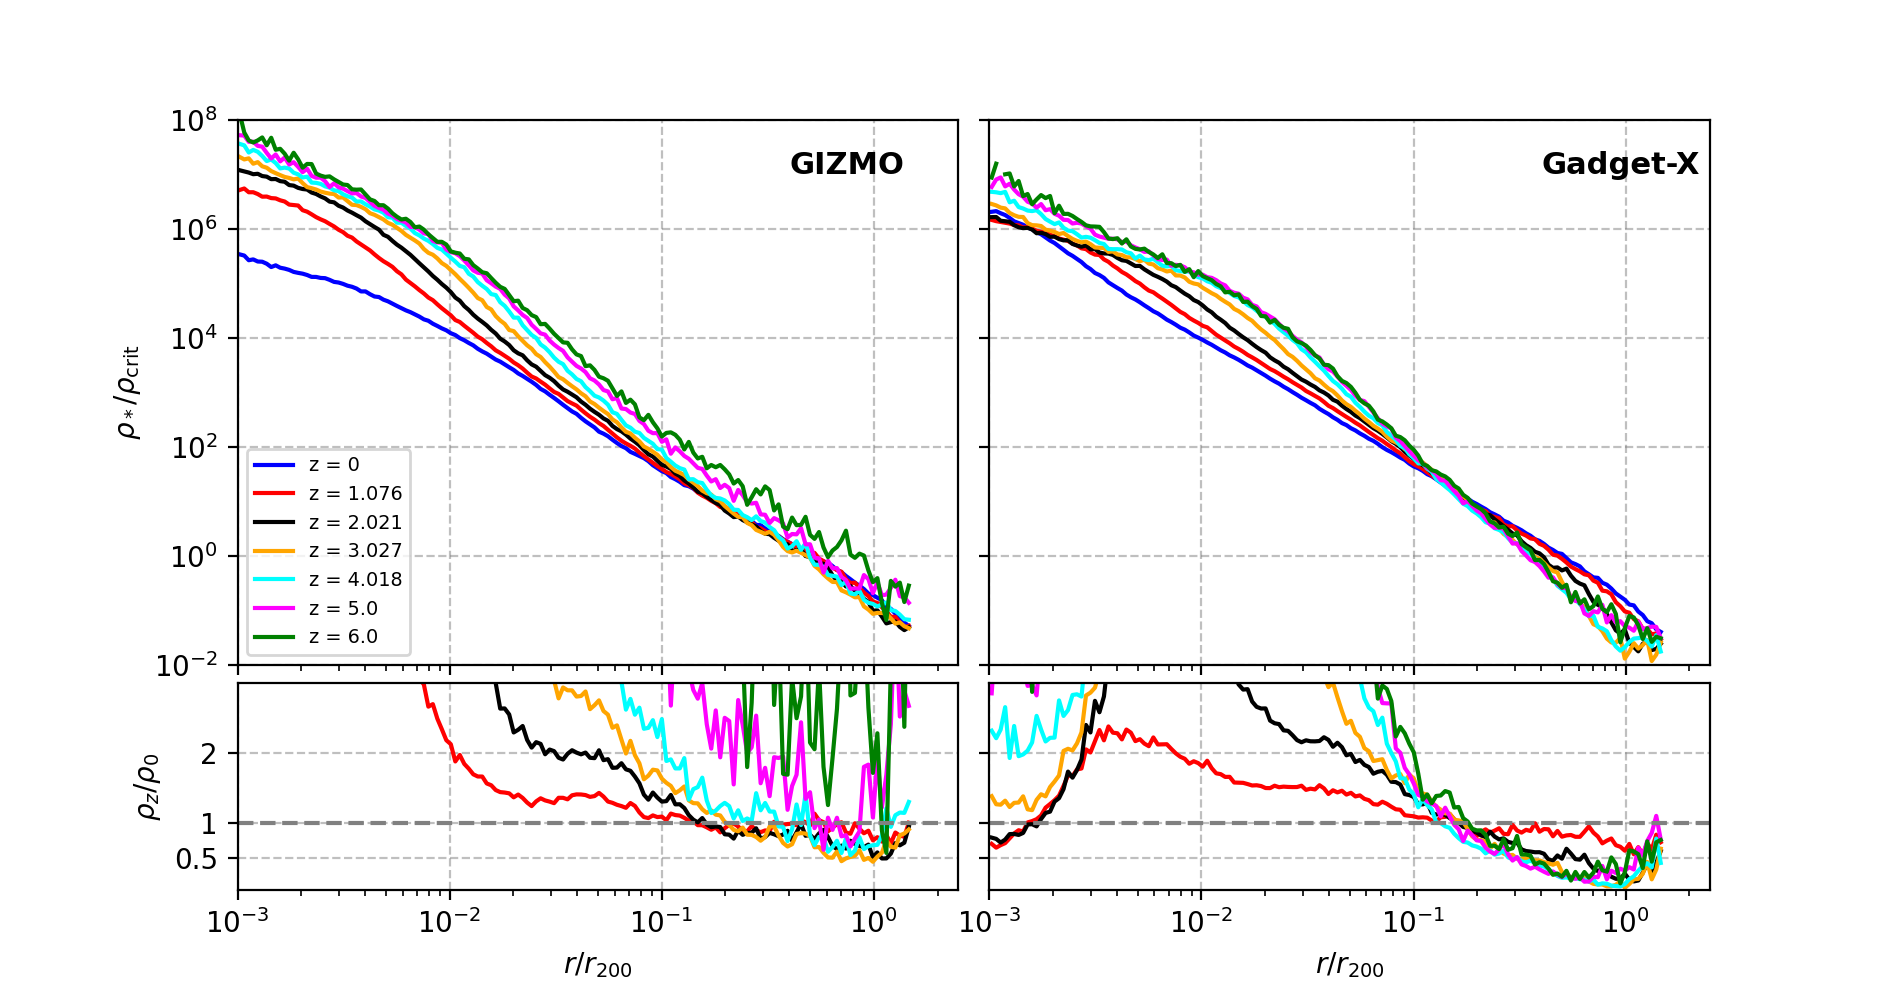

324
324
323
323
323
318
306
324
324
324
323
323
320
305


/home/qyli/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3334: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qyli/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


[]

In [ ]:
10**14.61